In [1]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy import stats

conn=wrds.Connection()



Enter your WRDS username [Pro]:alfgarar
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [2]:
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, b.ncusip, a.date, 
                      b.shrcd, b.exchcd, b.siccd,
                      a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2020'
                      and b.exchcd between -2 and 2
                      and b.shrcd between 10 and 11
                      """)

In [3]:
crsp_m

,permno,permco,ncusip,date,shrcd,exchcd,siccd,ret,vol,shrout,prc,cfacpr,cfacshr
0,10001.0,7953.0,29269V10,2009-12-31,11.0,2.0,4925.0,0.162621,7231.0,4361.0,10.300000,1.0,1.0
1,10001.0,7953.0,36720410,2011-03-31,11.0,2.0,4925.0,0.072404,4137.0,7834.0,11.730000,1.0,1.0
2,10001.0,7953.0,36720410,2011-04-29,11.0,2.0,4925.0,-0.038789,4109.0,8151.0,11.230000,1.0,1.0
3,10001.0,7953.0,36720410,2011-05-31,11.0,2.0,4925.0,0.028050,4979.0,8151.0,11.500000,1.0,1.0
4,10001.0,7953.0,36720410,2011-06-30,11.0,2.0,4925.0,0.008261,2472.0,8151.0,11.550000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714593,91915.0,52115.0,17243V10,2011-10-31,11.0,1.0,7832.0,0.094809,218604.0,114203.0,20.670000,1.0,1.0
714594,91915.0,52115.0,17243V10,2011-11-30,11.0,1.0,7832.0,-0.042090,280390.0,114203.0,19.590000,1.0,1.0
714595,91915.0,52115.0,17243V10,2011-12-30,11.0,1.0,7832.0,-0.056151,407145.0,114203.0,18.490000,1.0,1.0
714596,91915.0,52115.0,17243V10,2012-01-31,11.0,1.0,7832.0,0.066522,186844.0,114203.0,19.719999,1.0,1.0


In [4]:
crsp_m.to_excel("Data_for_Momentum_Example.xlsx")

In [4]:
# Change variable format to int
crsp_m[['permco', 'permno','shrcd','exchcd']]=crsp_m[['permco', 'permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m[['date']]=pd.to_datetime(crsp_m['date'])
crsp_m[['date']]


,date
0,2011-03-31
1,2014-07-31
2,2014-08-29
3,2014-09-30
4,2014-10-31
...,...
714593,2011-04-29
714594,2011-05-31
714595,2011-06-30
714596,2011-07-29


In [5]:
#######################################################
# Create Momentum Portfolio                           #   
# Measures Based on Past (J) Month Compounded Returns #
#######################################################

J = 6 # Formation Period Length: J can be between 3 to 12 months
K = 6 # Holding Period Length: K can be between 3 to 12 months

_tmp_crsp = crsp_m[['permno','date','ret']].sort_values(['permno','date']).set_index('date')

#Replace missing returns with 0
_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)
_tmp_crsp


,permno,ret
date,,
2009-12-31,10001,0.162621
2010-01-29,10001,-0.018932
2010-02-26,10001,-0.000656
2010-03-31,10001,0.020643
2010-04-30,10001,0.124385
...,...,...
2019-08-30,93426,-0.232941
2019-09-30,93426,0.047680
2019-10-31,93426,0.040012


In [6]:
#Calculate rolling cummulative return by summing log(1+ret) over the formation period
_tmp_crsp['logret']= np.log(1+_tmp_crsp['ret'])
umd= _tmp_crsp.groupby(['permno'])['logret'].rolling(J,min_periods=J).sum()
umd=umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1
umd=umd.dropna(axis=0,subset=['cumret'])
umd

,permno,date,logret,cumret
5,10001,2010-05-28,0.273393,0.314417
6,10001,2010-06-30,0.078324,0.081473
7,10001,2010-07-30,0.177481,0.194205
8,10001,2010-08-31,0.060183,0.062031
9,10001,2010-09-30,0.113521,0.120216
...,...,...,...,...
714593,93426,2019-08-30,-0.109321,-0.103557
714594,93426,2019-09-30,-0.043920,-0.042970
714595,93426,2019-10-31,-0.106329,-0.100871
714596,93426,2019-11-29,-0.040159,-0.039363


In [7]:
#######################################################################
# Formation of 10 Momentum Portfolios, one portfolio for each decile  #
#######################################################################

# For each date: assign ranking 1-10 based on cumret
# 1=lowest 10=highest cumret

umd['momr']=umd.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))
umd.momr=umd.momr.astype(int)
umd.momr=umd.momr+1
umd

,permno,date,logret,cumret,momr
5,10001,2010-05-28,0.273393,0.314417,9
6,10001,2010-06-30,0.078324,0.081473,8
7,10001,2010-07-30,0.177481,0.194205,8
8,10001,2010-08-31,0.060183,0.062031,8
9,10001,2010-09-30,0.113521,0.120216,8
...,...,...,...,...,...
714593,93426,2019-08-30,-0.109321,-0.103557,5
714594,93426,2019-09-30,-0.043920,-0.042970,4
714595,93426,2019-10-31,-0.106329,-0.100871,4
714596,93426,2019-11-29,-0.040159,-0.039363,3


In [8]:
# First lineup date to month end date medate
# Then calculate hdate1 and hdate2 using medate

umd['form_date']=umd['date']
umd['medate'] = umd['date']+MonthEnd(0)
umd['hdate1']=umd['medate']+MonthBegin(1)
umd['hdate2']=umd['medate']+MonthEnd(K)
umd = umd[['permno', 'form_date','momr','hdate1','hdate2']]
umd

,permno,form_date,momr,hdate1,hdate2
5,10001,2010-05-28,9,2010-06-01,2010-11-30
6,10001,2010-06-30,8,2010-07-01,2010-12-31
7,10001,2010-07-30,8,2010-08-01,2011-01-31
8,10001,2010-08-31,8,2010-09-01,2011-02-28
9,10001,2010-09-30,8,2010-10-01,2011-03-31
...,...,...,...,...,...
714593,93426,2019-08-30,5,2019-09-01,2020-02-29
714594,93426,2019-09-30,4,2019-10-01,2020-03-31
714595,93426,2019-10-31,4,2019-11-01,2020-04-30
714596,93426,2019-11-29,3,2019-12-01,2020-05-31


In [9]:
# join rank and return data together
# note: this step consumes a lot of memory so takes a while

_tmp_ret=crsp_m[['permno','date','ret']]
port = pd.merge(_tmp_ret,umd, on=['permno'],how='inner')






In [10]:
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]
port

,permno,date,ret,form_date,momr,hdate1,hdate2
4,10001,2011-03-31,0.072404,2010-09-30,8,2010-10-01,2011-03-31
5,10001,2011-03-31,0.072404,2010-10-29,7,2010-11-01,2011-04-30
6,10001,2011-03-31,0.072404,2010-11-30,2,2010-12-01,2011-05-31
7,10001,2011-03-31,0.072404,2010-12-31,2,2011-01-01,2011-06-30
8,10001,2011-03-31,0.072404,2011-01-31,2,2011-02-01,2011-07-31
...,...,...,...,...,...,...,...
144844544,93247,2011-08-31,0.004734,2011-03-31,9,2011-04-01,2011-09-30
144844545,93247,2011-08-31,0.004734,2011-04-29,10,2011-05-01,2011-10-31
144844546,93247,2011-08-31,0.004734,2011-05-31,10,2011-06-01,2011-11-30
144844547,93247,2011-08-31,0.004734,2011-06-30,10,2011-07-01,2011-12-31


In [11]:
umd2 = port.sort_values(by=['date','momr','form_date','permno']).drop_duplicates()
umd2

,permno,date,ret,form_date,momr,hdate1,hdate2
219222,10048,1990-07-31,-0.104478,1990-06-29,1,1990-07-01,1990-12-31
358886,10123,1990-07-31,-0.057143,1990-06-29,1,1990-07-01,1990-12-31
973990,10285,1990-07-31,-0.076923,1990-06-29,1,1990-07-01,1990-12-31
1440236,10455,1990-07-31,-0.250000,1990-06-29,1,1990-07-01,1990-12-31
1902172,10594,1990-07-31,-0.060000,1990-06-29,1,1990-07-01,1990-12-31
...,...,...,...,...,...,...,...
144128054,92692,2019-12-31,-0.050928,2019-11-29,10,2019-12-01,2020-05-31
144205488,92797,2019-12-31,0.249436,2019-11-29,10,2019-12-01,2020-05-31
144385596,93035,2019-12-31,0.055631,2019-11-29,10,2019-12-01,2020-05-31
144632220,93246,2019-12-31,0.021218,2019-11-29,10,2019-12-01,2020-05-31


In [12]:
umd3 = umd2.groupby(['date','momr','form_date'])['ret'].mean().reset_index()
# Skip first two years of the sample 
start_yr = umd3['date'].dt.year.min()+2
umd3 = umd3[umd3['date'].dt.year>=start_yr]
umd3 = umd3.sort_values(by=['date','momr'])
umd3

,date,momr,form_date,ret
930,1992-01-31,1,1991-07-31,0.447708
931,1992-01-31,1,1991-08-30,0.483559
932,1992-01-31,1,1991-09-30,0.579933
933,1992-01-31,1,1991-10-31,0.488595
934,1992-01-31,1,1991-11-29,0.514332
...,...,...,...,...
21085,2019-12-31,10,2019-07-31,0.010360
21086,2019-12-31,10,2019-08-30,0.005223
21087,2019-12-31,10,2019-09-30,0.012113
21088,2019-12-31,10,2019-10-31,0.023859


In [13]:
# Create one return series per MOM group every month
ewret = umd3.groupby(['date','momr'])['ret'].mean().reset_index()
ewstd = umd3.groupby(['date','momr'])['ret'].std().reset_index()
ewret = ewret.rename(columns={'ret':'ewret'})
ewstd = ewstd.rename(columns={'ret':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','momr'], how='inner')
ewretdat = ewretdat.sort_values(by=['momr'])
# portfolio summary
ewretdat.groupby(['momr'])['ewret'].describe()[['count','mean', 'std']]

,count,mean,std
momr,,,
1,336.0,0.010856,0.097606
2,336.0,0.009833,0.064886
3,336.0,0.010698,0.055246
4,336.0,0.011059,0.048774
5,336.0,0.011317,0.044722
6,336.0,0.010790,0.042446
7,336.0,0.010988,0.041089
8,336.0,0.010633,0.041979
9,336.0,0.011240,0.044693


In [14]:
#################################
# Long-Short Portfolio Returns  #
#################################

# Transpose portfolio layout to have columns as portfolio returns
ewretdat2 = ewretdat.pivot(index='date', columns='momr', values='ewret')

# Add prefix port in front of each column
ewretdat2 = ewretdat2.add_prefix('port')
ewretdat2 = ewretdat2.rename(columns={'port1':'losers', 'port10':'winners'})
ewretdat2['long_short'] = ewretdat2['winners'] - ewretdat2['losers']

ewretdat2

momr,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
date,,,,,,,,,,,
1992-01-31,0.511771,0.172385,0.126781,0.089274,0.090365,0.061053,0.052700,0.043026,0.064655,0.144559,-0.367212
1992-02-28,0.067830,0.058125,0.053517,0.046551,0.043171,0.045191,0.032291,0.032499,0.047281,0.049161,-0.018669
1992-03-31,-0.059724,-0.021687,-0.017317,-0.016005,-0.016433,-0.015467,-0.010332,-0.015380,-0.019305,-0.023858,0.035866
1992-04-30,-0.058899,-0.016142,-0.011839,-0.004193,-0.000567,0.003797,-0.004762,-0.011929,-0.017332,-0.055770,0.003129
1992-05-29,0.021183,0.006599,0.008339,0.001298,0.008009,0.003616,0.004837,0.004707,-0.006406,-0.014300,-0.035482
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,-0.102663,-0.097315,-0.071096,-0.068740,-0.057786,-0.047013,-0.028512,-0.022220,-0.021441,-0.022846,0.079817
2019-09-30,0.121297,0.076775,0.052580,0.058468,0.052000,0.047936,0.035973,0.029743,0.016188,-0.008845,-0.130142
2019-10-31,-0.033740,-0.016313,-0.006969,0.004564,0.009244,0.014495,0.006194,0.006771,0.006244,0.010642,0.044383


In [15]:
# Compute Long-Short Portfolio Cumulative Returns
ewretdat3 = ewretdat2
ewretdat3['1+losers']=1+ewretdat3['losers']
ewretdat3['1+winners']=1+ewretdat3['winners']
ewretdat3['1+ls'] = 1+ewretdat3['long_short']

ewretdat3['cumret_winners']=ewretdat3['1+winners'].cumprod()-1
ewretdat3['cumret_losers']=ewretdat3['1+losers'].cumprod()-1
ewretdat3['cumret_long_short']=ewretdat3['1+ls'].cumprod()-1
ewretdat3

momr,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short,1+losers,1+winners,1+ls,cumret_winners,cumret_losers,cumret_long_short
date,,,,,,,,,,,,,,,,,
1992-01-31,0.511771,0.172385,0.126781,0.089274,0.090365,0.061053,0.052700,0.043026,0.064655,0.144559,-0.367212,1.511771,1.144559,0.632788,0.144559,0.511771,-0.367212
1992-02-28,0.067830,0.058125,0.053517,0.046551,0.043171,0.045191,0.032291,0.032499,0.047281,0.049161,-0.018669,1.067830,1.049161,0.981331,0.200827,0.614314,-0.379025
1992-03-31,-0.059724,-0.021687,-0.017317,-0.016005,-0.016433,-0.015467,-0.010332,-0.015380,-0.019305,-0.023858,0.035866,0.940276,0.976142,1.035866,0.172177,0.517900,-0.356753
1992-04-30,-0.058899,-0.016142,-0.011839,-0.004193,-0.000567,0.003797,-0.004762,-0.011929,-0.017332,-0.055770,0.003129,0.941101,0.944230,1.003129,0.106805,0.428497,-0.354740
1992-05-29,0.021183,0.006599,0.008339,0.001298,0.008009,0.003616,0.004837,0.004707,-0.006406,-0.014300,-0.035482,1.021183,0.985700,0.964518,0.090978,0.458757,-0.377636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,-0.102663,-0.097315,-0.071096,-0.068740,-0.057786,-0.047013,-0.028512,-0.022220,-0.021441,-0.022846,0.079817,0.897337,0.977154,1.079817,36.556937,6.070642,-0.274850
2019-09-30,0.121297,0.076775,0.052580,0.058468,0.052000,0.047936,0.035973,0.029743,0.016188,-0.008845,-0.130142,1.121297,0.991155,0.869858,36.224756,6.928288,-0.369222
2019-10-31,-0.033740,-0.016313,-0.006969,0.004564,0.009244,0.014495,0.006194,0.006771,0.006244,0.010642,0.044383,0.966260,1.010642,1.044383,36.620915,6.660785,-0.341227


In [16]:
#################################
# Portfolio Summary Statistics  #
################################# 

# Mean 
mom_mean = ewretdat3[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewretdat3['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewretdat3['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewretdat3['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')
mom_output

,momr,mean,t-stat,p-value
0,winners,0.012678,4.089066,0.000054
1,losers,0.010856,2.038677,0.042267
2,long_short,0.001822,0.456515,0.648315


In [ ]:
x= ewretdat3.index
y1=  ewretdat3['cumret_winners']
y2=  ewretdat3['cumret_losers']
fig= plt.figure(figsize=(15,6))
plt.plot(x, y1,label = "winners")
plt.plot(x, y2,label = "losers")
plt.legend()
plt.title('Cummulative returns best and worst momentum deciles')

ewretdat3['cumret_winners']

Text(0.5, 1.0, 'Cummulative returns of long-short momentum portfolio')

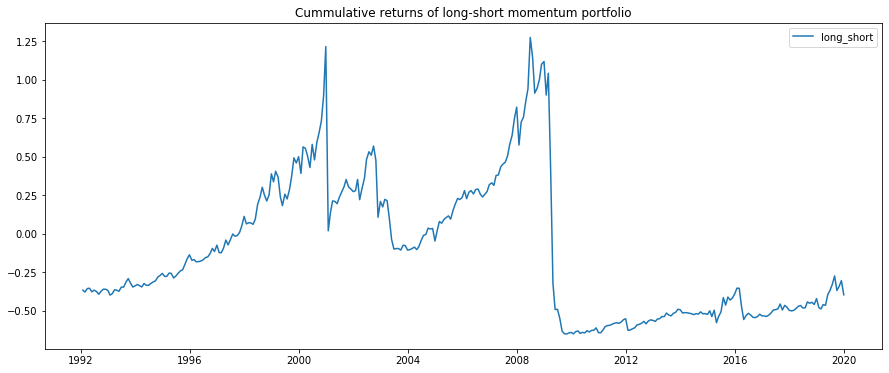

In [22]:
x= ewretdat3.index
y1=  ewretdat3['cumret_long_short']
fig= plt.figure(figsize=(15,6))
plt.plot(x, y1,label = "long_short")
plt.legend()
plt.title('Cummulative returns of long-short momentum portfolio')
